# Install and load packages

In [2]:
pip install pandas numpy seaborn matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Laod the data set

In [7]:
file_path = r"C:\ArmedForces_PrEP.csv" 
df = pd.read_csv(file_path)

# Display Bacis Informations

In [277]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 36 columns):
 #   Column                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                --------------  -----  
 0   Gender                                                                                                                                400 non-null    object 
 1   Service Arm                                                                                                                           400 non-null    object 
 2   Educational Qualification                                                                                                             400 non-null    object 
 3   Rank                                                                       

# Data Cleaning & Preprocessing: Handle Missing Values & Encode Categorical Data

In [18]:
import pandas as pd
import numpy as np
import os

def clean_armed_forces_prep_data(file_path):
    """
    Clean and preprocess the ArmedForces PrEP dataset
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pd.DataFrame: Cleaned dataframe
    """
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Read the dataset
    print(f"Reading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Make a copy of the original data
    original_df = df.copy()
    
    # Display initial information
    print(f"Original dataset shape: {df.shape}")
    print(f"Number of columns: {len(df.columns)}")
    
    # 1. Remove duplicates
    df_no_dupes = df.drop_duplicates()
    print(f"Removed {len(df) - len(df_no_dupes)} duplicate rows")
    df = df_no_dupes
    
    # 2. Standardize column names
    df.columns = [col.strip().replace(' ', '_') for col in df.columns]
    
    # 3. Handle missing values
    missing_values = df.isnull().sum()
    print("\nMissing values before cleaning:")
    print(missing_values[missing_values > 0])
    
    # For numeric columns, fill NaNs with median
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill NaNs with mode
    cat_cols = df.select_dtypes(include=['object', 'bool']).columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # 4. Standardize categorical variables
    
    # Standardize boolean responses
    bool_cols = [col for col in df.columns if any(word in col.lower() for word in ['is', 'have', 'can', 'should', 'would', 'will'])]
    bool_mapping = {
        'TRUE': True, 'True': True, 'yes': True, 'Yes': True, 'Y': True,
        'FALSE': False, 'False': False, 'no': False, 'No': False, 'N': False
    }
    
    for col in bool_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map(bool_mapping)
            # If mapping didn't work (not all values were in the mapping dict), keep as is
            if df[col].isna().any():
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # 5. Convert Likert scale responses to numeric
    likert_mapping = {
        'Strongly Disagree': 1,
        'Disagree': 2,
        'Neutral': 3,
        'Agree': 4,
        'Strongly Agree': 5
    }
    
    likert_cols = [col for col in df.columns if df[col].dtype == 'object' and 
                   df[col].str.contains('Agree|Disagree', na=False).any()]
    
    for col in likert_cols:
        df[col] = df[col].map(likert_mapping)
    
    # 6. Handle age outliers - cap at reasonable values for military personnel
    if 'Age_at_last_birthday' in df.columns:
        df['Age_at_last_birthday'] = df['Age_at_last_birthday'].clip(18, 70)
    
    # 7. Standardize service arm names
    if 'Service_Arm' in df.columns:
        df['Service_Arm'] = df['Service_Arm'].str.title()
        # Create mapping for common service arm variations
        service_mapping = {
            'Army': 'Army',
            'Nigerian Army': 'Army',
            'Na': 'Army',
            'Air Force': 'Air Force',
            'Naf': 'Air Force',
            'Nigerian Air Force': 'Air Force',
            'Navy': 'Navy',
            'Nigerian Navy': 'Navy',
            'Nn': 'Navy'
        }
        df['Service_Arm'] = df['Service_Arm'].map(lambda x: service_mapping.get(x, x))
    
    # 8. Create derived features
    
    # Calculate age groups
    if 'Age_at_last_birthday' in df.columns:
        df['Age_Group'] = pd.cut(df['Age_at_last_birthday'], 
                                bins=[17, 25, 35, 45, 55, 71],
                                labels=['18-25', '26-35', '36-45', '46-55', '56-70'])
    
    # Normalize scores to 0-1 range for consistency
    score_cols = [col for col in df.columns if 'Score' in col]
    for col in score_cols:
        if df[col].max() > 1:
            max_possible = {
                'PrEP_Knowledge_Score': 9.0,  # Assuming 9 knowledge questions
                'Attitude_Score': 5.0,        # Based on Likert scale
                'Barriers_Score': 5.0,        # Based on Likert scale
                'PrEP_use_Score': 1.0        # Binary outcome
            }.get(col, df[col].max())
            
            df[f'{col}_Normalized'] = df[col] / max_possible
    
    # 9. Final check for any remaining missing values
    missing_after = df.isnull().sum()
    if missing_after.sum() > 0:
        print("\nRemaining missing values after cleaning:")
        print(missing_after[missing_after > 0])
    else:
        print("\nNo missing values remain after cleaning.")
    
    # 10. Generate cleaning report
    print("\nData Cleaning Summary:")
    print(f"Original shape: {original_df.shape}")
    print(f"Cleaned shape: {df.shape}")
    print(f"Columns standardized: {len(df.columns)}")
    print(f"Missing values handled: {missing_values.sum()}")
    
    # Save cleaned data
    cleaned_file_path = file_path.replace('.csv', '_cleaned.csv')
    df.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned data saved to: {cleaned_file_path}")
    
    return df

if __name__ == "__main__":
    file_path = r"C:\ArmedForces_PrEP.csv"
    try:
        cleaned_df = clean_armed_forces_prep_data(file_path)
        print("Data cleaning completed successfully!")
    except Exception as e:
        print(f"Error cleaning data: {e}")

Reading data from C:\ArmedForces_PrEP.csv...
Original dataset shape: (400, 36)
Number of columns: 36
Removed 59 duplicate rows

Missing values before cleaning:
If_no_to_question_above,_how_likely_are_you_to_start_using_PrEP_for_HIV_prevention_in_the_near_future?    126
dtype: int64
Error cleaning data: 0


# Decriptive Statistics
    

## 1.	Summary statistics for demographic variables (age, years of service)

In [39]:
import pandas as pd

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# 📌 Convert categorical Years of Military Service to numeric (using midpoints)
years_mapping = {
    "0 - 10 Years": 5,
    "11 - 20 Years": 15,
    "21 - 30 Years": 25,
    "31 - 40 Years": 35,
    "41+ Years": 45
}
df["Years of Military Service"] = df["Years of Military Service"].map(years_mapping)

# 📌 Summary Statistics for Age and Years of Service
summary_stats = df[['Age at last birthday', 'Years of Military Service']].describe()

print(summary_stats)

       Age at last birthday  Years of Military Service
count             400.00000                 372.000000
mean               34.30500                  11.639785
std                 9.23337                   7.577049
min                20.00000                   5.000000
25%                26.00000                   5.000000
50%                33.00000                   5.000000
75%                40.00000                  15.000000
max                59.00000                  25.000000


## 2.	Frequency distributions for categorical variables (gender, service arm, education, rank, marital status)

In [41]:
import pandas as pd

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# 📌 List of categorical variables
categorical_vars = ["Gender", "Service Arm", "Educational Qualification", "Rank", "Marital Status"]

# 📌 Frequency Distribution for each categorical variable
for var in categorical_vars:
    print(f"\n📊 Frequency Distribution for {var}:\n")
    print(df[var].value_counts())
    print("-" * 50)


📊 Frequency Distribution for Gender:

Gender
Male      280
Female    120
Name: count, dtype: int64
--------------------------------------------------

📊 Frequency Distribution for Service Arm:

Service Arm
Army         160
Air Force    120
Navy         120
Name: count, dtype: int64
--------------------------------------------------

📊 Frequency Distribution for Educational Qualification:

Educational Qualification
Tertiary    213
SSCE        187
Name: count, dtype: int64
--------------------------------------------------

📊 Frequency Distribution for Rank:

Rank
Other Rank    293
Officers      107
Name: count, dtype: int64
--------------------------------------------------

📊 Frequency Distribution for Marital Status:

Marital Status
Married          198
Single           193
Separated          5
Divorced           2
Widow/Widower      2
Name: count, dtype: int64
--------------------------------------------------


## 3.	Distribution analysis of knowledge scores, attitude scores, and barriers scores


📊 Summary Statistics for Knowledge, Attitude, and Barriers Scores:

       PrEP_Knowledge_Score  Attitude_Score  Barriers_Score
count            400.000000      400.000000       400.00000
mean               1.333500        2.919950         2.78400
std                0.239837        0.470813         0.54081
min                1.000000        1.250000         1.20000
25%                1.100000        2.630000         2.40000
50%                1.300000        3.000000         2.80000
75%                1.500000        3.250000         3.20000
max                2.000000        4.000000         4.00000


C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


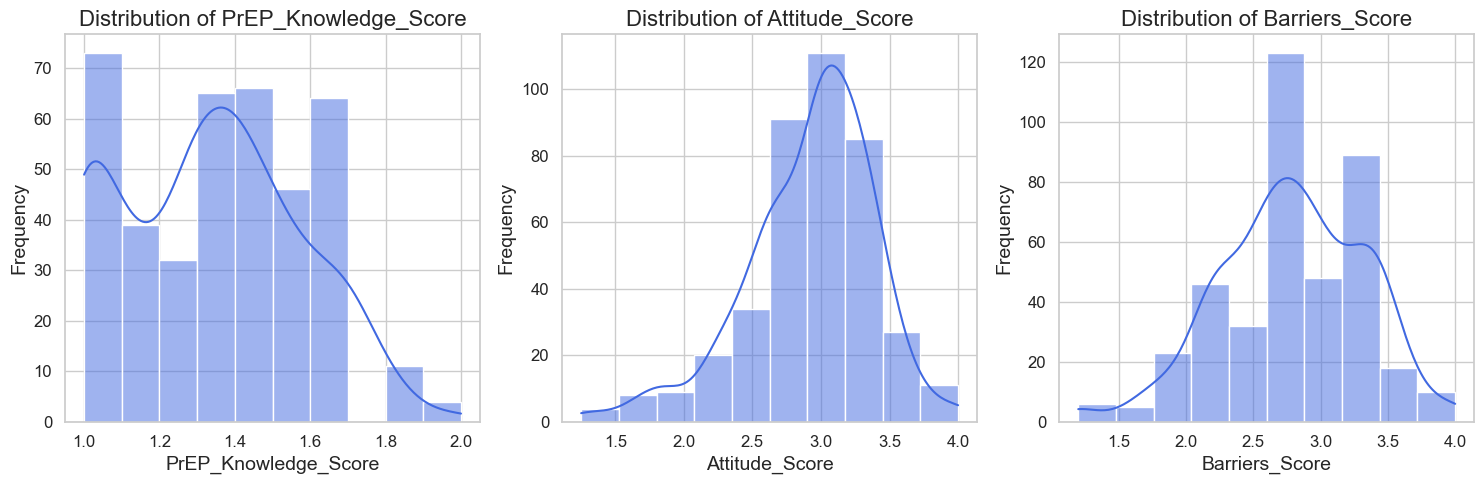

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Ensure correct path
df = pd.read_csv(file_path)

# 📌 Summary Statistics for Scores
score_vars = ["PrEP_Knowledge_Score", "Attitude_Score", "Barriers_Score"]
summary_stats = df[score_vars].describe()

print("\n📊 Summary Statistics for Knowledge, Attitude, and Barriers Scores:\n")
print(summary_stats)

# 📊 **Visualizing Distribution Using Histograms & KDE Plots**
plt.figure(figsize=(15, 5))

for i, var in enumerate(score_vars):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[var], bins=10, kde=True, color="royalblue")
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 4.	Cross-tabulations between demographic characteristics and PrEP knowledge/attitudes

In [45]:
import pandas as pd

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Update with correct path
df = pd.read_csv(file_path)

# 📌 Define categorical demographics
demographic_vars = ["Gender", "Service Arm", "Educational Qualification", "Rank", "Marital Status"]

# 📌 Define target variables (PrEP Knowledge & Attitude)
target_vars = ["PrEP_Knowledge_Score", "Attitude_Score"]

# 📊 **Generate Cross-Tabulations**
for demo in demographic_vars:
    for target in target_vars:
        print(f"\n📊 Cross-Tabulation: {demo} vs {target}\n")
        print(pd.crosstab(df[demo], pd.cut(df[target], bins=4), normalize='index') * 100)  # Normalize for percentage
        print("-" * 50)


📊 Cross-Tabulation: Gender vs PrEP_Knowledge_Score

PrEP_Knowledge_Score  (0.999, 1.25]  (1.25, 1.5]  (1.5, 1.75]  (1.75, 2.0]
Gender                                                                    
Female                    24.166667    56.666667    15.000000     4.166667
Male                      41.071429    38.928571    16.428571     3.571429
--------------------------------------------------

📊 Cross-Tabulation: Gender vs Attitude_Score

Attitude_Score  (1.247, 1.938]  (1.938, 2.625]  (2.625, 3.312]  (3.312, 4.0]
Gender                                                                      
Female                4.166667       15.833333       55.000000     25.000000
Male                  5.357143       12.857143       67.857143     13.928571
--------------------------------------------------

📊 Cross-Tabulation: Service Arm vs PrEP_Knowledge_Score

PrEP_Knowledge_Score  (0.999, 1.25]  (1.25, 1.5]  (1.5, 1.75]  (1.75, 2.0]
Service Arm                                              

# Inferential Statistics

## 1. Chi-square tests to examine relationships between categorical variables

In [47]:
import pandas as pd
import scipy.stats as stats

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Update with correct path
df = pd.read_csv(file_path)

# 📌 Convert categorical response variables into numeric categories for Chi-Square analysis
response_mapping = {
    "Strongly Agree": 5, "Agree": 4, "Neutral": 3, "Disagree": 2, "Strongly Disagree": 1,
    "Yes": 1, "No": 0, "TRUE": 1, "FALSE": 0
}
df.replace(response_mapping, inplace=True)

# 📌 Define categorical demographics and target variables
demographic_vars = ["Gender", "Service Arm", "Educational Qualification", "Rank", "Marital Status"]
target_vars = ["PrEP_Knowledge_Score", "Attitude_Score", "Barriers_Score"]

# 📊 Perform Chi-Square Tests
for demo in demographic_vars:
    for target in target_vars:
        # Convert continuous scores into categorical bins
        df[target + "_Category"] = pd.cut(df[target], bins=3, labels=["Low", "Moderate", "High"])
        
        # Create contingency table
        contingency_table = pd.crosstab(df[demo], df[target + "_Category"])

        # Perform Chi-Square Test
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

        # Print results
        print(f"\n📌 Chi-Square Test: {demo} vs {target}")
        print(f"Chi-Square Statistic = {chi2:.2f}, p-value = {p:.4f}")
        print("-" * 50)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\4218329047.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(response_mapping, inplace=True)



📌 Chi-Square Test: Gender vs PrEP_Knowledge_Score
Chi-Square Statistic = 3.36, p-value = 0.1860
--------------------------------------------------

📌 Chi-Square Test: Gender vs Attitude_Score
Chi-Square Statistic = 3.75, p-value = 0.1534
--------------------------------------------------

📌 Chi-Square Test: Gender vs Barriers_Score
Chi-Square Statistic = 0.60, p-value = 0.7411
--------------------------------------------------

📌 Chi-Square Test: Service Arm vs PrEP_Knowledge_Score
Chi-Square Statistic = 21.46, p-value = 0.0003
--------------------------------------------------

📌 Chi-Square Test: Service Arm vs Attitude_Score
Chi-Square Statistic = 3.35, p-value = 0.5013
--------------------------------------------------

📌 Chi-Square Test: Service Arm vs Barriers_Score
Chi-Square Statistic = 9.14, p-value = 0.0577
--------------------------------------------------

📌 Chi-Square Test: Educational Qualification vs PrEP_Knowledge_Score
Chi-Square Statistic = 20.03, p-value = 0.0000
---

## 2.	t-tests or ANOVA to compare knowledge, attitude, and barriers scores across different demographic groups

In [51]:
import pandas as pd
import scipy.stats as stats

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Update with correct path
df = pd.read_csv(file_path)

# 📌 Convert categorical responses to numeric
response_mapping = {
    "Strongly Agree": 5, "Agree": 4, "Neutral": 3, "Disagree": 2, "Strongly Disagree": 1,
    "Yes": 1, "No": 0, "TRUE": 1, "FALSE": 0
}

# ✅ Apply mapping & explicitly infer objects to avoid FutureWarning
df = df.replace(response_mapping).infer_objects(copy=False)

# 📌 Select numerical score variables
score_vars = ["PrEP_Knowledge_Score", "Attitude_Score", "Barriers_Score"]

# 📌 Function to perform **T-Tests** (For Two-Group Comparisons)
def perform_ttest(group_var):
    unique_values = df[group_var].dropna().unique()
    if len(unique_values) == 2:  # Ensure only two groups exist for t-test
        print(f"\n📌 T-Test for {group_var}")
        for score in score_vars:
            group1 = df[df[group_var] == unique_values[0]][score]
            group2 = df[df[group_var] == unique_values[1]][score]
            t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
            print(f"{score}: t-stat = {t_stat:.2f}, p-value = {p_value:.4f}")
        print("-" * 50)

# 📌 Function to perform **ANOVA** (For Multiple-Group Comparisons)
def perform_anova(group_var):
    unique_values = df[group_var].dropna().unique()
    if len(unique_values) > 2:  # Ensure multiple groups exist for ANOVA
        print(f"\n📌 ANOVA for {group_var}")
        for score in score_vars:
            groups = [df[df[group_var] == val][score] for val in unique_values]
            f_stat, p_value = stats.f_oneway(*groups)  # One-way ANOVA
            print(f"{score}: F-stat = {f_stat:.2f}, p-value = {p_value:.4f}")
        print("-" * 50)

# 📌 Run T-Tests for Two-Group Variables
perform_ttest("Gender")  # Male vs. Female
perform_ttest("Rank")  # Officer vs. Other Rank

# 📌 Run ANOVA for Multi-Group Variables
perform_anova("Service Arm")  # Army, Navy, Air Force
perform_anova("Educational Qualification")  # Primary, Secondary, Tertiary
perform_anova("Marital Status")  # Married, Single, Divorced, Widowed

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\1840525024.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(response_mapping).infer_objects(copy=False)



📌 T-Test for Gender
PrEP_Knowledge_Score: t-stat = -2.18, p-value = 0.0298
Attitude_Score: t-stat = -1.60, p-value = 0.1103
Barriers_Score: t-stat = -1.15, p-value = 0.2524
--------------------------------------------------

📌 T-Test for Rank
PrEP_Knowledge_Score: t-stat = -2.61, p-value = 0.0096
Attitude_Score: t-stat = 1.53, p-value = 0.1267
Barriers_Score: t-stat = 3.97, p-value = 0.0001
--------------------------------------------------

📌 ANOVA for Service Arm
PrEP_Knowledge_Score: F-stat = 8.49, p-value = 0.0002
Attitude_Score: F-stat = 1.89, p-value = 0.1519
Barriers_Score: F-stat = 2.74, p-value = 0.0656
--------------------------------------------------

📌 ANOVA for Marital Status
PrEP_Knowledge_Score: F-stat = 6.48, p-value = 0.0000
Attitude_Score: F-stat = 5.34, p-value = 0.0003
Barriers_Score: F-stat = 4.79, p-value = 0.0009
--------------------------------------------------


## 3. Correlation analysis between:
### (i) Age and PrEP knowledge/attitudes
### (ii) Years of service and PrEP knowledge/attitudes
### (iii) Knowledge scores and attitude scores

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\4284120319.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(response_mapping).infer_objects(copy=False)



📌 Pearson Correlation Matrix:
                            Age at last birthday  Years of Military Service  \
Age at last birthday                   1.000000                   0.803060   
Years of Military Service              0.803060                   1.000000   
PrEP_Knowledge_Score                   0.196883                   0.152372   
Attitude_Score                        -0.100581                  -0.076226   

                           PrEP_Knowledge_Score  Attitude_Score  
Age at last birthday                   0.196883       -0.100581  
Years of Military Service              0.152372       -0.076226  
PrEP_Knowledge_Score                   1.000000       -0.269890  
Attitude_Score                        -0.269890        1.000000  


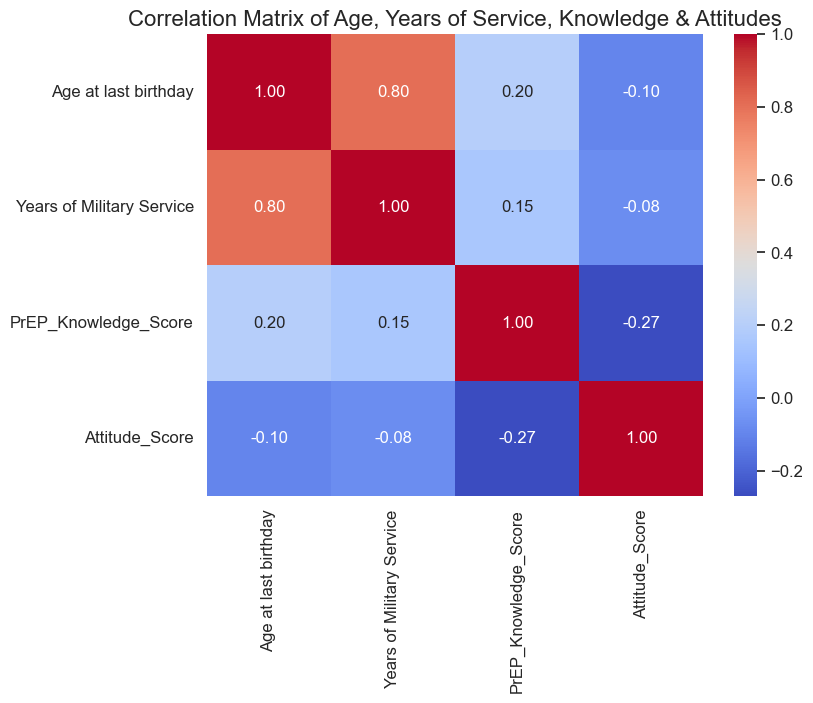


📌 Correlation between Age at last birthday and PrEP_Knowledge_Score:
Pearson Correlation Coefficient = 0.20, p-value = 0.0001
--------------------------------------------------

📌 Correlation between Age at last birthday and Attitude_Score:
Pearson Correlation Coefficient = -0.10, p-value = 0.0526
--------------------------------------------------

📌 Correlation between Years of Military Service and PrEP_Knowledge_Score:
Pearson Correlation Coefficient = 0.15, p-value = 0.0032
--------------------------------------------------

📌 Correlation between Years of Military Service and Attitude_Score:
Pearson Correlation Coefficient = -0.08, p-value = 0.1423
--------------------------------------------------

📌 Correlation between PrEP_Knowledge_Score and Attitude_Score:
Pearson Correlation Coefficient = -0.27, p-value = 0.0000
--------------------------------------------------


In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"  # Update with correct path
df = pd.read_csv(file_path)

# 📌 Convert categorical responses to numeric
response_mapping = {
    "Strongly Agree": 5, "Agree": 4, "Neutral": 3, "Disagree": 2, "Strongly Disagree": 1,
    "Yes": 1, "No": 0, "TRUE": 1, "FALSE": 0
}
df = df.replace(response_mapping).infer_objects(copy=False)

# 📌 Convert "Years of Military Service" to numeric values
years_mapping = {
    "0 - 10 Years": 5,
    "11 - 20 Years": 15,
    "21 - 30 Years": 25,
    "31 - 40 Years": 35,
    "41+ Years": 45
}
df["Years of Military Service"] = df["Years of Military Service"].map(years_mapping)

# ✅ Drop rows with NaN values in relevant columns
df_clean = df.dropna(subset=["Age at last birthday", "Years of Military Service", 
                             "PrEP_Knowledge_Score", "Attitude_Score"])

# 📊 **Correlation Matrix**
correlation_matrix = df_clean[["Age at last birthday", "Years of Military Service", 
                               "PrEP_Knowledge_Score", "Attitude_Score"]].corr(method="pearson")

print("\n📌 Pearson Correlation Matrix:\n", correlation_matrix)

# 📊 **Visualizing Correlation Matrix (Heatmap)**
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Age, Years of Service, Knowledge & Attitudes")
plt.show()

# 📌 **Individual Pearson Correlation Tests**
def correlation_test(var1, var2):
    # Ensure no NaN values before testing
    df_subset = df_clean[[var1, var2]].dropna()
    corr, p_value = stats.pearsonr(df_subset[var1], df_subset[var2])
    print(f"\n📌 Correlation between {var1} and {var2}:")
    print(f"Pearson Correlation Coefficient = {corr:.2f}, p-value = {p_value:.4f}")
    print("-" * 50)

# Run correlation tests
correlation_test("Age at last birthday", "PrEP_Knowledge_Score")
correlation_test("Age at last birthday", "Attitude_Score")
correlation_test("Years of Military Service", "PrEP_Knowledge_Score")
correlation_test("Years of Military Service", "Attitude_Score")
correlation_test("PrEP_Knowledge_Score", "Attitude_Score")

# Predictive Analyses & Machine Learning

# 1.	Regression Models: 
     


## (i) Multiple linear regression to predict knowledge, attitude, or barrier scores


In [146]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"
df = pd.read_csv(file_path)

# 📌 Convert categorical responses to numeric
response_mapping = {
    "Strongly Agree": 5, "Agree": 4, "Neutral": 3, "Disagree": 2, "Strongly Disagree": 1,
    "Yes": 1, "No": 0, "TRUE": 1, "FALSE": 0
}
df = df.replace(response_mapping)

# 📌 Convert "Years of Military Service" to numeric values
years_mapping = {
    "0 - 10 Years": 5,
    "11 - 20 Years": 15,
    "21 - 30 Years": 25,
    "31 - 40 Years": 35,
    "41+ Years": 45
}
df["Years of Military Service"] = df["Years of Military Service"].map(years_mapping)

# 📌 Encode categorical demographic variables
df = pd.get_dummies(df, columns=["Gender", "Service Arm", "Educational Qualification", "Rank", "Marital Status"], drop_first=True)

# ✅ **Ensure Boolean Variables Are Converted to Integers**
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

# 📌 Define independent variables (predictors)
X = df[["Age at last birthday", "Years of Military Service"] + list(df.filter(like="_").columns)]

# 📌 Define dependent variable (target)
y = df["PrEP_Knowledge_Score"]  # Change to "Attitude_Score" or "Barriers_Score" as needed

# ✅ **Drop NaN values to avoid regression errors**
df_clean = df.dropna(subset=["PrEP_Knowledge_Score", "Age at last birthday", "Years of Military Service"])

# ✅ **Convert all data to numeric format**
X = df_clean[["Age at last birthday", "Years of Military Service"] + list(df_clean.filter(like="_").columns)]
y = df_clean["PrEP_Knowledge_Score"]

X = X.apply(pd.to_numeric, errors="coerce")  # Ensure numeric format
y = pd.to_numeric(y, errors="coerce")

# ✅ **Ensure No Missing Values Before Running Regression**
X = X.dropna()
y = y[X.index]  # Match index

# 📌 Add constant for regression
X = sm.add_constant(X)

# 📊 **Fit Multiple Linear Regression Model**
model = sm.OLS(y, X).fit()

# 📌 Print Summary of the Model
print(model.summary())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\3052338753.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(response_mapping)


                             OLS Regression Results                             
Dep. Variable:     PrEP_Knowledge_Score   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                  1.000
Method:                   Least Squares   F-statistic:                 4.752e+28
Date:                  Thu, 06 Mar 2025   Prob (F-statistic):               0.00
Time:                          19:44:15   Log-Likelihood:                 11690.
No. Observations:                   372   AIC:                        -2.335e+04
Df Residuals:                       356   BIC:                        -2.328e+04
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

## (ii) Logistic regression to predict PrEP consideration or potential use

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load your data (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Map textual responses to numeric values for known responses
response_mapping = {
    "Yes": 1, "No": 0,
    "Agree": 1, "Disagree": 0,
    "Strongly Agree": 1, "Strongly Disagree": 0
}
df.replace(response_mapping, inplace=True)

# Display initial data preview and information
print("Data preview:")
print(df.head())
print("\nTotal rows:", len(df))
print("Available columns:")
print(df.columns.tolist())

# Specify the target column exactly as it appears in your DataFrame.
# In this example, we use:
target_column = "Have you ever considered using Pre-Exposure Prophylaxis (PrEP) for HIV prevention?"

# Check if the target column exists
if target_column not in df.columns:
    raise KeyError(f"Target column '{target_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

# Drop rows with missing values in the target column
df = df.dropna(subset=[target_column])

# Separate features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

# Fill any remaining NaN values in features (you can adjust the strategy if needed)
X = X.fillna(0)

# Convert categorical features to numeric using one-hot encoding
# This converts columns like 'Gender' into numeric dummy variables.
X = pd.get_dummies(X, drop_first=True)

print("\nShape of features after encoding:", X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and fit the Logistic Regression model
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optionally, display model coefficients and intercept
print("\nModel Coefficients:", logreg.coef_)
print("Model Intercept:", logreg.intercept_)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\609911487.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(response_mapping, inplace=True)


Data preview:
   Gender Service Arm Educational Qualification        Rank  \
0    Male        Army                  Tertiary  Other Rank   
1    Male        Army                      SSCE  Other Rank   
2    Male        Army                      SSCE  Other Rank   
3  Female        Army                  Tertiary  Other Rank   
4  Female        Army                  Tertiary  Other Rank   

   Age at last birthday Years of Military Service Marital Status  \
0                    49             21 - 30 Years        Married   
1                    25              0 - 10 Years         Single   
2                    32             11 - 20 Years         Single   
3                    48             21 - 30 Years        Married   
4                    38             11 - 20 Years         Single   

   Have you ever heard about Pre-Exposure Prophylaxis (PrEP)?  \
0                                                  1            
1                                                  1            
2  

# Classification Models: 



## (i) Decision trees to identify factors influencing PrEP consideration

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\2513193659.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(response_mapping, inplace=True)



Using column 'have_you_ever_considered_using_pre-exposure_prophylaxis_(prep)_for_hiv_prevention' as target variable.

Unique values in target variable: [1 0]

Final Data Size: X=(400, 45), y=(400,)

Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        25

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\2513193659.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[target_column].fillna(0, inplace=True)  # Fill missing target values


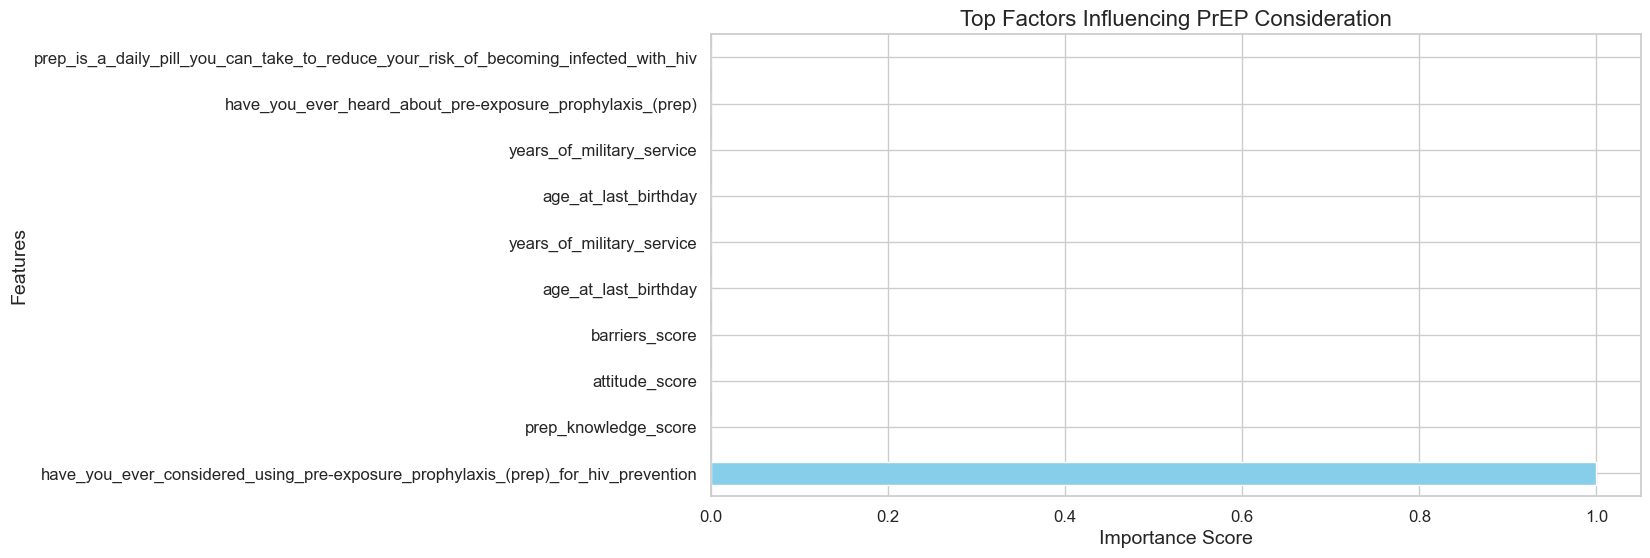

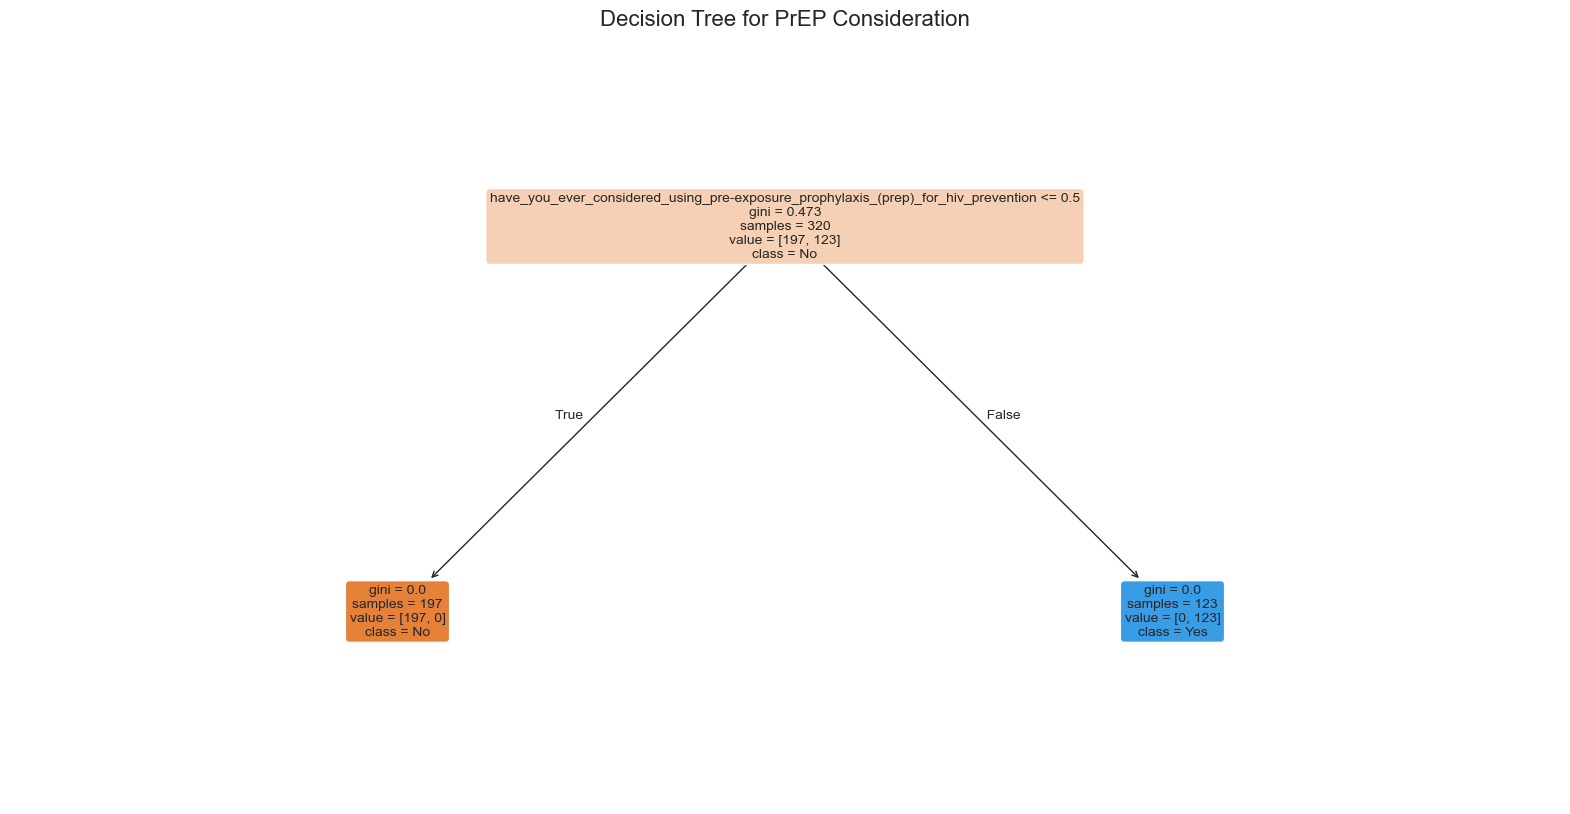

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"
df = pd.read_csv(file_path)

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace("?", "").str.replace(" ", "_")

# Convert categorical responses to numeric
response_mapping = {
    "Strongly Agree": 5, "Agree": 4, "Neutral": 3, "Disagree": 2, "Strongly Disagree": 1,
    "Yes": 1, "No": 0, "TRUE": 1, "FALSE": 0,
    "Likely": 1, "Very Likely": 1,
    "Unlikely": 0, "Very Unlikely": 0
}
df.replace(response_mapping, inplace=True)

# Convert "Years of Military Service" to numeric values
years_mapping = {
    "0 - 10 Years": 5,
    "11 - 20 Years": 15,
    "21 - 30 Years": 25,
    "31 - 40 Years": 35,
    "41+ Years": 45
}
df["years_of_military_service"] = df["years_of_military_service"].map(years_mapping)

# Encode categorical demographic variables
df = pd.get_dummies(df, columns=["gender", "service_arm", "educational_qualification", "rank", "marital_status"], drop_first=True)

# Convert Boolean Variables to Integers
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

# Find the correct column name dynamically
target_column = [col for col in df.columns if "prep" in col and "considered" in col]
if not target_column:
    raise KeyError("Target column for PrEP consideration not found. Check column names.")
else:
    target_column = target_column[0]

print(f"\nUsing column '{target_column}' as target variable.")

# Convert target variable (y) to binary format (0/1)
df[target_column].fillna(0, inplace=True)  # Fill missing target values

# Ensure correct mapping
print("\nUnique values in target variable:", df[target_column].unique())

# Define independent variables (predictors)
selected_features = ["prep_knowledge_score", "attitude_score", "barriers_score", "age_at_last_birthday", "years_of_military_service"]

# Ensure selected features exist in the dataset
for feature in selected_features:
    if feature not in df.columns:
        raise KeyError(f"Feature '{feature}' not found in dataset. Check column names.")

X = df[selected_features + list(df.filter(like="_").columns)]
y = df[target_column]

# Convert all features in X to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values in X with mean
X.fillna(X.mean(numeric_only=True), inplace=True)

# Ensure X and y are not empty before proceeding
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("After cleaning, X or y has zero samples. Adjust feature selection or check missing values.")

print(f"\nFinal Data Size: X={X.shape}, y={y.shape}")

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate Model Performance
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Visualization
plt.figure(figsize=(12, 6))
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind="barh", color="skyblue")
plt.title("Top Factors Influencing PrEP Consideration")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Visualizing the Decision Tree
plt.figure(figsize=(20, 10)) #Increase figure size for better readability
plot_tree(clf, feature_names=X.columns, class_names=["No", "Yes"], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for PrEP Consideration")
plt.show()

## (ii) Random forest to detect complex patterns in PrEP attitudes and barriers

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load your data (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Map known textual responses to numeric values
response_mapping = {
    "Yes": 1, "No": 0,
    "Agree": 1, "Disagree": 0,
    "Strongly Agree": 1, "Strongly Disagree": 0
}
df.replace(response_mapping, inplace=True)

# Set the target variable.
# In this example, we use "PrEP_use_Score" as the outcome variable.
target = "PrEP_use_Score"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in DataFrame. Available columns: {df.columns.tolist()}")

# Drop rows with missing values in the target column
df = df.dropna(subset=[target])

# Separate features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

# Fill any remaining missing values in features with 0 (or choose another strategy)
X = X.fillna(0)

# Convert categorical features to numeric using one-hot encoding.
# This ensures that all features are numeric for the Random Forest.
X = pd.get_dummies(X, drop_first=True)
print("\nShape of features after encoding:", X.shape)

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("\nRandom Forest Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optionally, display feature importances to see which variables are most influential
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\3750515195.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(response_mapping, inplace=True)



Shape of features after encoding: (400, 45)

Random Forest Model Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        55

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Feature Importances:
                                              Feature  Importance
24  Have you ever considered using Pre-Exposure Pr...    0.542669
41  If no to question above, how likely are you to...    0.105214
40  If no to question above, how likely are you to...    0.054896
1   Have you ever heard about Pre-Exposure Prophyl...    0.033940
27                                     Barriers_Score    0.022452
43  If no to question above, how likely are you to...    0.020175
25                               PrEP_Knowledge_Score    0.019295
26                 

# Clustering Analyses

## (i) K-means clustering to identify natural groupings in attitude and knowledge patterns

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\206599766.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


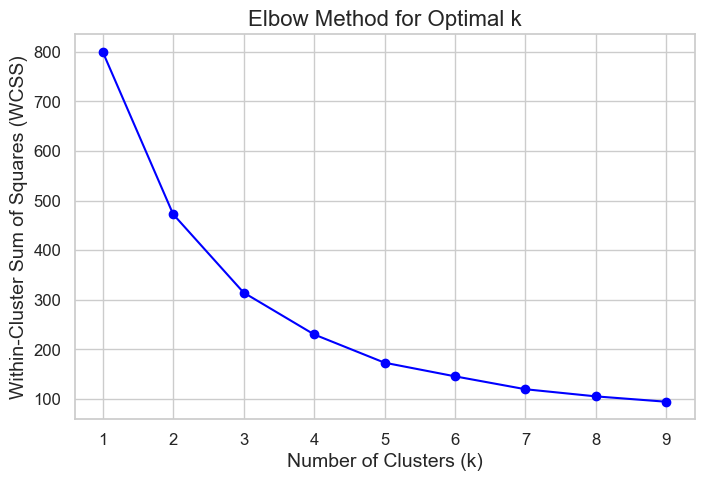

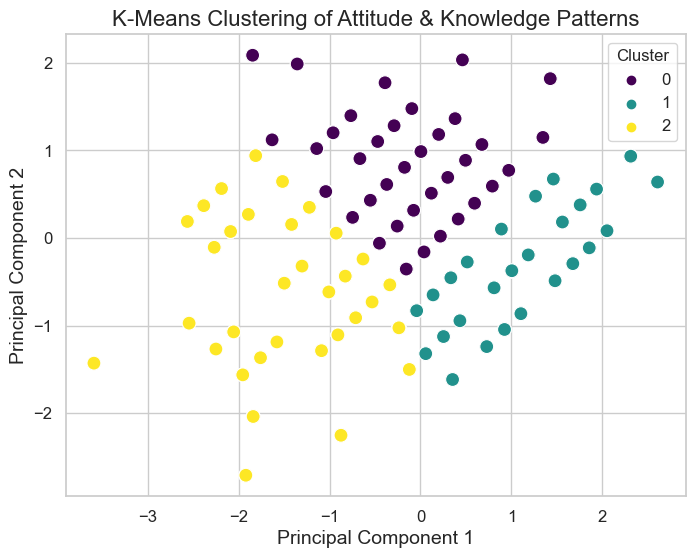


📌 Cluster Counts:
 Cluster
0    168
1    131
2    101
Name: count, dtype: int64

📌 Cluster Centers (Original Scale):
    prep_knowledge_score  attitude_score
0              1.474405        3.134464
1              1.062595        3.123588
2              1.450495        2.299010


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"
df = pd.read_csv(file_path)

# 📌 Standardize column names: Strip spaces, lowercase, remove special characters
df.columns = df.columns.str.strip().str.lower().str.replace("?", "").str.replace(" ", "_")

# ✅ **Select Relevant Features for Clustering**
clustering_features = ["prep_knowledge_score", "attitude_score"]

# ✅ **Ensure features exist in dataset**
for feature in clustering_features:
    if feature not in df.columns:
        raise KeyError(f"Feature '{feature}' not found in dataset. Check column names.")

X = df[clustering_features]

# ✅ **Handle Missing Values**
X.fillna(X.mean(), inplace=True)

# ✅ **Standardize Features (Important for K-Means)**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📊 **Elbow Method to Determine Optimal `k`**
wcss = []  # Within-cluster sum of squares
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 📊 **Plot Elbow Curve**
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()

# 📌 Choose optimal `k` (based on elbow method, e.g., 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# 📊 **Visualizing Clusters using PCA**
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Cluster"], palette="viridis", s=100)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering of Attitude & Knowledge Patterns")
plt.legend(title="Cluster")
plt.show()

# 📌 Print Cluster Counts
print("\n📌 Cluster Counts:\n", df["Cluster"].value_counts())

# 📌 Print Cluster Centers (Unscaled)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("\n📌 Cluster Centers (Original Scale):\n", pd.DataFrame(cluster_centers, columns=clustering_features))


## (ii) Hierarchical clustering to create profiles of military personnel based on PrEP perceptions

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\2321762475.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


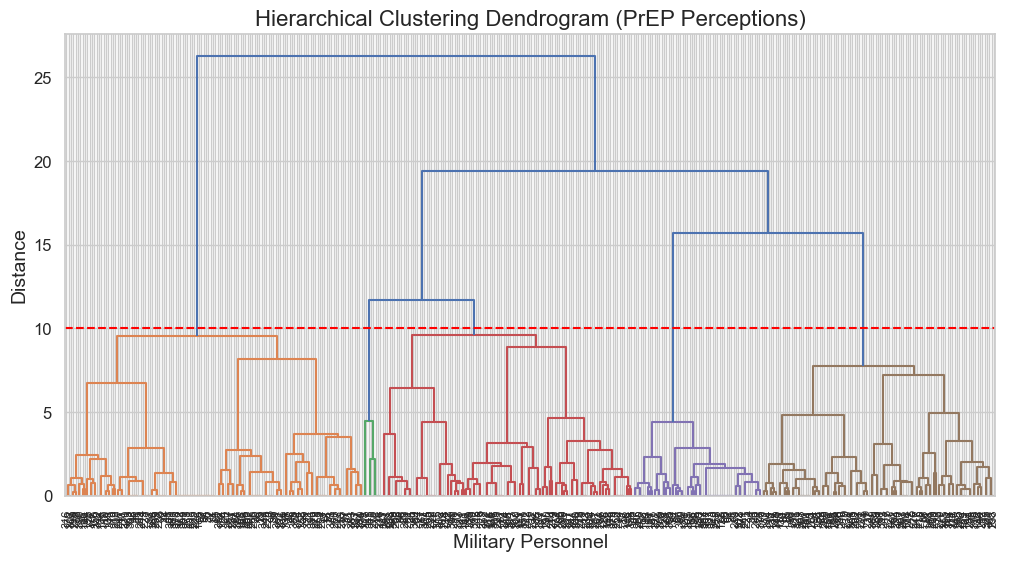

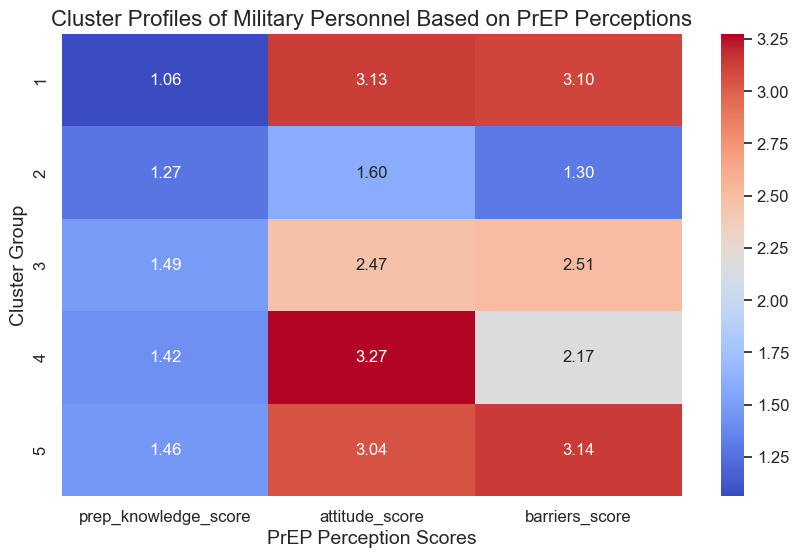


📌 Cluster Counts:
 Cluster
1    128
3    108
5    100
4     56
2      8
Name: count, dtype: int64

📌 Cluster Centers:
          prep_knowledge_score  attitude_score  barriers_score
Cluster                                                      
1                    1.062500        3.133203        3.103125
2                    1.275000        1.597500        1.300000
3                    1.492593        2.465741        2.505556
4                    1.421429        3.274107        2.175000
5                    1.464000        3.045000        3.136000


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"
df = pd.read_csv(file_path)

# 📌 Standardize column names: Strip spaces, lowercase, remove special characters
df.columns = df.columns.str.strip().str.lower().str.replace("?", "").str.replace(" ", "_")

# ✅ **Select Relevant Features for Clustering (Perceptions on PrEP)**
clustering_features = ["prep_knowledge_score", "attitude_score", "barriers_score"]

# ✅ **Ensure selected features exist in dataset**
for feature in clustering_features:
    if feature not in df.columns:
        raise KeyError(f"Feature '{feature}' not found in dataset. Check column names.")

X = df[clustering_features]

# ✅ **Handle Missing Values**
X.fillna(X.mean(), inplace=True)

# ✅ **Standardize Features (Important for Hierarchical Clustering)**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📊 **Compute Linkage Matrix for Hierarchical Clustering**
linkage_matrix = linkage(X_scaled, method="ward")  # "ward" minimizes variance within clusters

# 📊 **Plot Dendrogram**
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=8, color_threshold=10)
plt.axhline(y=10, color='red', linestyle='--')  # Cut-off threshold for clustering
plt.title("Hierarchical Clustering Dendrogram (PrEP Perceptions)")
plt.xlabel("Military Personnel")
plt.ylabel("Distance")
plt.show()

# 📌 Choose a cluster cut-off distance (e.g., height = 10) and assign cluster labels
df["Cluster"] = fcluster(linkage_matrix, t=10, criterion="distance")

# 📊 **Cluster Heatmap Visualization**
cluster_means = df.groupby("Cluster")[clustering_features].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Cluster Profiles of Military Personnel Based on PrEP Perceptions")
plt.xlabel("PrEP Perception Scores")
plt.ylabel("Cluster Group")
plt.show()

# 📌 Print Cluster Counts
print("\n📌 Cluster Counts:\n", df["Cluster"].value_counts())

# 📌 Print Cluster Centers (Unscaled)
print("\n📌 Cluster Centers:\n", cluster_means)

# Advanced ML Techniques 

## (i) Neural networks to predict PrEP uptake likelihood


📌 Using column 'have_you_ever_considered_using_pre-exposure_prophylaxis_(prep)_for_hiv_prevention' as target variable.

📌 Unique values in target variable after mapping: [1 0]

📌 Model Accuracy on Test Data: 0.6125

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.74        55
           1       0.29      0.16      0.21        25

    accuracy                           0.61        80
   macro avg       0.48      0.49      0.47        80
weighted avg       0.56      0.61      0.58        80



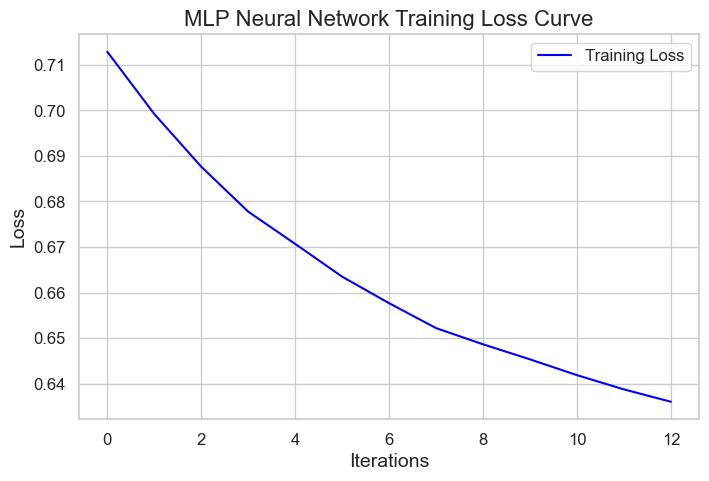

In [249]:
# ✅ Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# 📌 Load dataset
file_path = r"C:\ArmedForces_PrEP.csv"
df = pd.read_csv(file_path)

# 📌 Standardize column names: Strip spaces, lowercase, remove special characters
df.columns = df.columns.str.strip().str.lower().str.replace("?", "").str.replace(" ", "_")

# ✅ **Convert 'years_of_military_service' to numerical values**
years_mapping = {
    "0 - 10 Years": 5, "11 - 20 Years": 15, "21 - 30 Years": 25, "31 Years and Above": 35
}
df["years_of_military_service"] = df["years_of_military_service"].map(years_mapping)

# ✅ **Select Relevant Features for Prediction**
features = ["prep_knowledge_score", "attitude_score", "barriers_score", "age_at_last_birthday", "years_of_military_service"]

# ✅ **Ensure selected features exist in dataset**
for feature in features:
    if feature not in df.columns:
        raise KeyError(f"Feature '{feature}' not found in dataset. Check column names.")

X = df[features].copy()  # ✅ Avoiding chained assignment warning

# ✅ **Find the correct target column dynamically**
target_column = [col for col in df.columns if "prep" in col and "considered" in col]
if not target_column:
    raise KeyError("Target column for PrEP consideration not found. Check column names.")
else:
    target_column = target_column[0]  # Select the first match

print(f"\n📌 Using column '{target_column}' as target variable.")

# ✅ **Convert target variable (`y`) to binary format (0/1)**
target_mapping = {
    "Likely": 1, "Very Likely": 1, "Yes": 1,  
    "Unlikely": 0, "Very Unlikely": 0, "No": 0
}
df[target_column] = df[target_column].map(target_mapping)

# ✅ **Check for unique values and convert safely**
print("\n📌 Unique values in target variable after mapping:", df[target_column].unique())

# ✅ **Ensure target is numeric and has no missing values**
df[target_column] = df[target_column].fillna(0)  # ✅ Fill missing values first
df[target_column] = df[target_column].astype(int)  # ✅ Convert to integer safely

y = df[target_column]

# ✅ **Handle Missing Values in X**
X.fillna(X.mean(numeric_only=True), inplace=True)  # ✅ Avoid `FutureWarning`

# ✅ **Normalize Features for Neural Networks**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ **Split dataset into training (80%) and testing (20%) sets**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 📊 **Build MLP Neural Network Model with Improved Convergence**
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam",
                    alpha=0.0001, max_iter=1500, random_state=42, early_stopping=True)

# ✅ **Train the Model**
mlp.fit(X_train, y_train)

# 📌 Predict on test set
y_pred = mlp.predict(X_test)

# 📌 Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\n📌 Model Accuracy on Test Data: {accuracy:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 📊 **Plot Training Loss Curve**
plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_, label="Training Loss", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Neural Network Training Loss Curve")
plt.legend()
plt.show()

# Visualizations

## (i) Bar charts showing distribution of personnel by service arm, rank, education

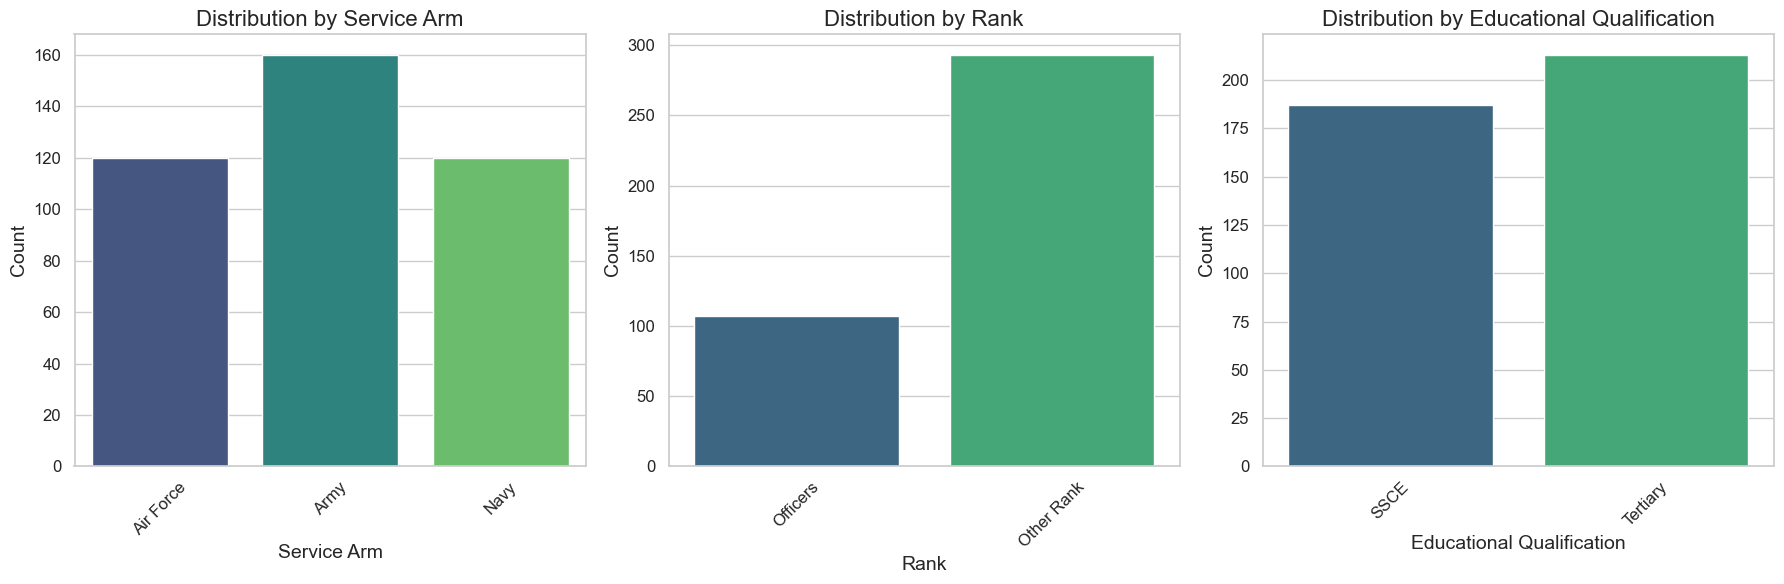

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# List of categories for which we want to create bar charts
categories = ['Service Arm', 'Rank', 'Educational Qualification']

# Create a figure with one row and three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Loop over each category and plot the bar chart
for i, category in enumerate(categories):
    # Count frequency of each unique value and sort (optional)
    counts = df[category].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Distribution by {category}")
    axes[i].set_xlabel(category)
    axes[i].set_ylabel("Count")
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## (ii) Age distribution histogram with overlay of years of service

Data preview:
   Age at last birthday Years of Military Service
0                    49             21 - 30 Years
1                    25              0 - 10 Years
2                    32             11 - 20 Years
3                    48             21 - 30 Years
4                    38             11 - 20 Years


C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


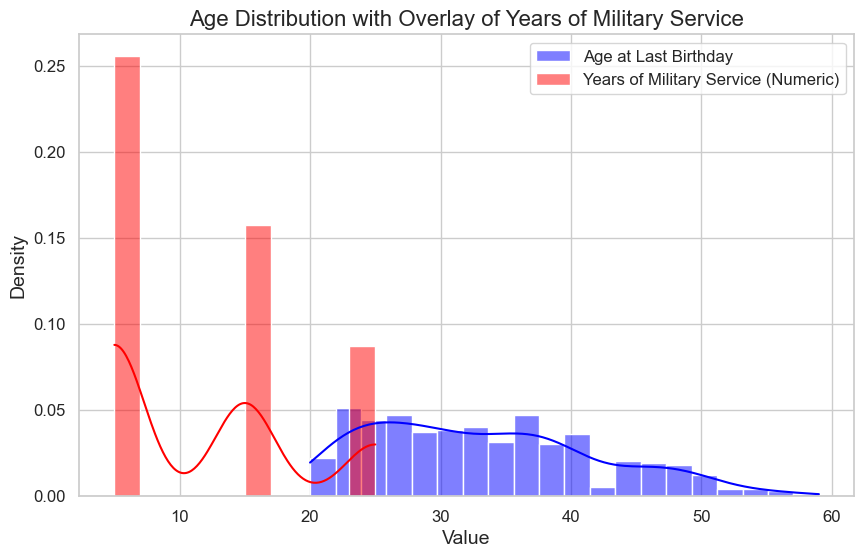

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Display a preview of the data
print("Data preview:")
print(df[['Age at last birthday', 'Years of Military Service']].head())

# Mapping for "Years of Military Service" to a numeric value (midpoint of each range)
service_mapping = {
    "0 - 10 Years": 5,
    "11 - 20 Years": 15,
    "21 - 30 Years": 25,
    "31 - 40 Years": 35,  # Add more mappings if applicable
    # If there are other ranges, include them here.
}

# Create a new numeric column for years of service using the mapping
df['ServiceYearsNumeric'] = df['Years of Military Service'].map(service_mapping)

# Drop rows with missing values in the columns of interest
df = df.dropna(subset=['Age at last birthday', 'ServiceYearsNumeric'])

# Plotting histograms with overlay
plt.figure(figsize=(10, 6))

# Histogram for Age at last birthday
sns.histplot(df['Age at last birthday'], color='blue', label='Age at Last Birthday',
             bins=20, kde=True, stat="density", alpha=0.5)

# Overlay histogram for Years of Military Service (numeric)
sns.histplot(df['ServiceYearsNumeric'], color='red', label='Years of Military Service (Numeric)',
             bins=10, kde=True, stat="density", alpha=0.5)

plt.title("Age Distribution with Overlay of Years of Military Service")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Knowledge Assessment

## (i) Radar chart showing correct/incorrect responses to PrEP knowledge questions

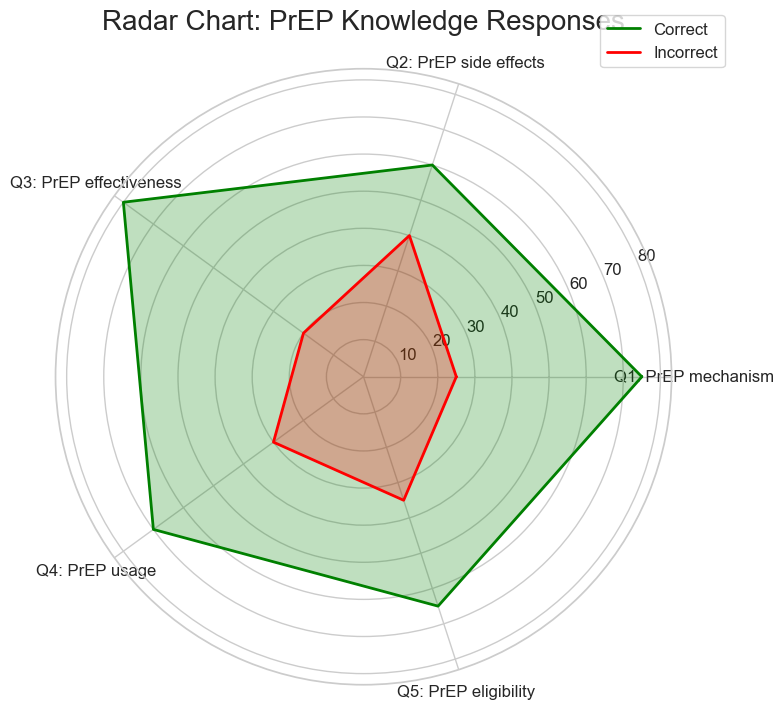

In [215]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: list of PrEP knowledge questions and aggregated counts
questions = [
    'Q1: PrEP mechanism', 
    'Q2: PrEP side effects', 
    'Q3: PrEP effectiveness', 
    'Q4: PrEP usage', 
    'Q5: PrEP eligibility'
]

# Replace these counts with your actual data
correct_counts = [75, 60, 80, 70, 65]
incorrect_counts = [25, 40, 20, 30, 35]

# Number of questions
num_questions = len(questions)

# Compute the angle for each axis in the radar chart (in radians)
angles = np.linspace(0, 2 * np.pi, num_questions, endpoint=False).tolist()

# The radar chart requires the data to be "closed" (repeat the first value at the end)
correct_counts += correct_counts[:1]
incorrect_counts += incorrect_counts[:1]
angles += angles[:1]
questions += questions[:1]

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the "Correct" responses line and fill the area
ax.plot(angles, correct_counts, color='green', linewidth=2, label='Correct')
ax.fill(angles, correct_counts, color='green', alpha=0.25)

# Plot the "Incorrect" responses line and fill the area
ax.plot(angles, incorrect_counts, color='red', linewidth=2, label='Incorrect')
ax.fill(angles, incorrect_counts, color='red', alpha=0.25)

# Set the labels for each axis
ax.set_thetagrids(np.degrees(angles[:-1]), questions[:-1])

# Set chart title and legend
ax.set_title("Radar Chart: PrEP Knowledge Responses", size=20, y=1.05)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

## (ii) Stacked bar chart comparing knowledge scores across demographic groups

Available columns: ['Gender', 'Service Arm', 'Educational Qualification', 'Rank', 'Age at last birthday', 'Years of Military Service', 'Marital Status', 'Have you ever heard about Pre-Exposure Prophylaxis (PrEP)?', 'PrEP is a daily pill you can take to reduce your risk of becoming infected with HIV?', "You should not use PrEP if you don't know your HIV status", 'PrEP can be used to prevent STIs like gonorrhea, chlamydia, syphilis, herpes, and HPV', 'If you start taking PrEP, you will have to take it for the rest of your life', 'PrEP can be taken by people who already have HIV', 'You must take an HIV test every 3 months while taking PrEP', 'Daily PrEP is very effective in preventing HIV transmission and using it can lower the risk of getting HIV from sex by more than 90%', 'PrEP is available within the military healthcare system in Nigeria and military personnel can easily access it', 'PrEP can provide complete protection against HIV transmission', 'PrEP is an effective method for preve

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10684\908559863.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([demographic, 'Knowledge_Category']).size().unstack(fill_value=0)



Grouped Data:
Knowledge_Category  Low  Medium  High
Gender                               
Female               29      46    45
Male                115      85    80


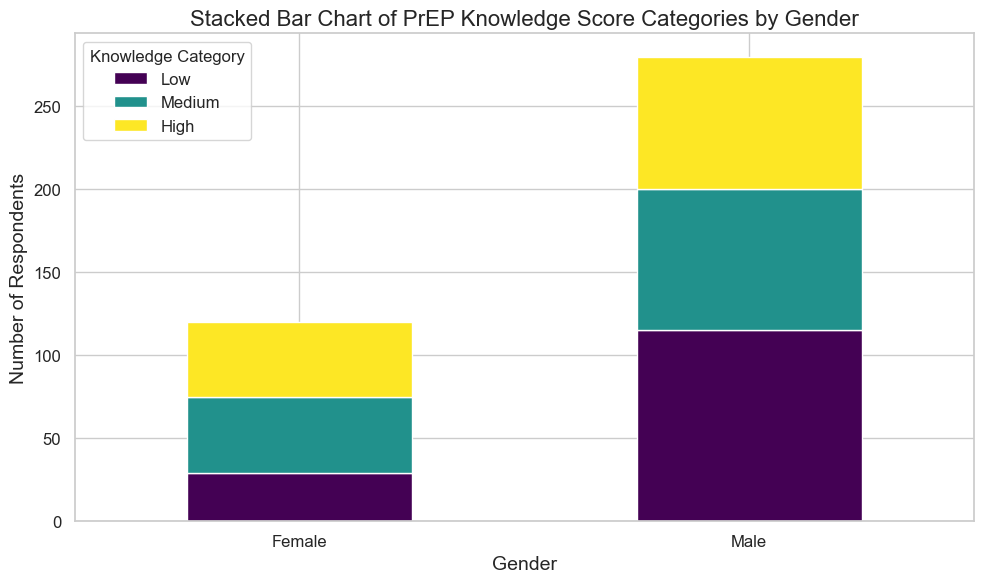

In [217]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Verify the required columns are available
print("Available columns:", df.columns.tolist())

# We'll assume the demographic group is 'Gender'
# and the knowledge score column is 'PrEP_Knowledge_Score'
demographic = "Gender"
knowledge_score = "PrEP_Knowledge_Score"

# Drop rows with missing values in the selected columns
df = df.dropna(subset=[demographic, knowledge_score])

# Define bins to categorize the knowledge scores.
# Here we create three bins: Low (<1.2), Medium (1.2-1.4), and High (>=1.4)
bins = [0, 1.2, 1.4, df[knowledge_score].max() + 0.1]
labels = ['Low', 'Medium', 'High']
df['Knowledge_Category'] = pd.cut(df[knowledge_score], bins=bins, labels=labels, include_lowest=True)

# Group the data by demographic (Gender) and the new knowledge category, and count the occurrences
grouped = df.groupby([demographic, 'Knowledge_Category']).size().unstack(fill_value=0)
print("\nGrouped Data:")
print(grouped)

# Plot a stacked bar chart using the grouped data
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Stacked Bar Chart of PrEP Knowledge Score Categories by Gender", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Number of Respondents", fontsize=14)
plt.legend(title="Knowledge Category", fontsize=12, title_fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Attitude & Barrier Analysis

## (i) Likert scale visualization for attitude questions

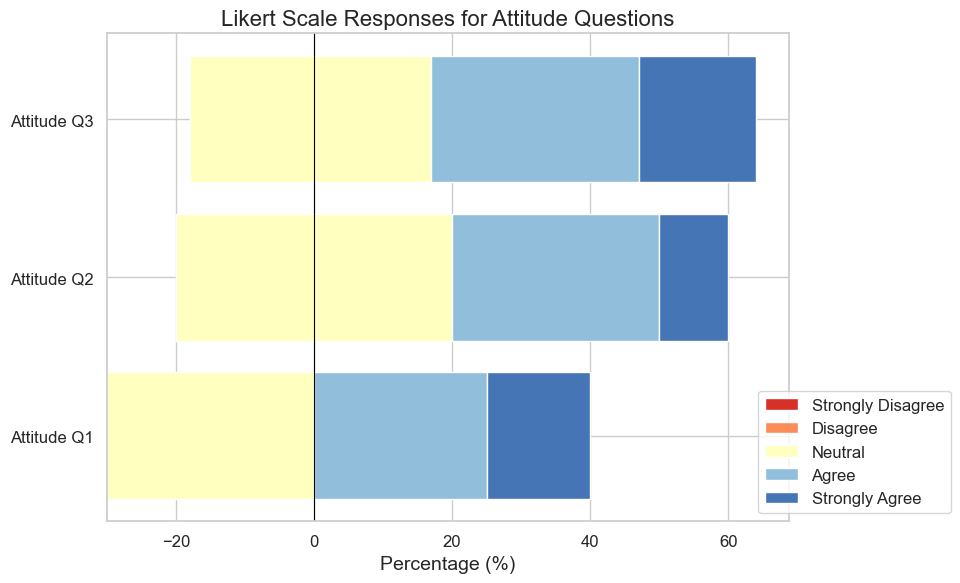

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample aggregated data for three attitude questions
data = {
    "Question": ["Attitude Q1", "Attitude Q2", "Attitude Q3"],
    "Strongly Disagree": [10, 5, 8],
    "Disagree": [20, 15, 10],
    "Neutral": [30, 40, 35],
    "Agree": [25, 30, 30],
    "Strongly Agree": [15, 10, 17]
}

# Create a DataFrame from the sample data
df_likert = pd.DataFrame(data)

# Calculate row totals for percentage computation
df_likert["Total"] = df_likert[["Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree"]].sum(axis=1)

# Convert counts to percentages
for col in ["Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree"]:
    df_likert[col] = df_likert[col] / df_likert["Total"] * 100

# For a diverging chart, convert disagree responses to negative values
df_likert["Strongly Disagree"] = -df_likert["Strongly Disagree"]
df_likert["Disagree"] = -df_likert["Disagree"]

# Define the order of categories and colors for each
categories = ["Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree"]
colors = {
    "Strongly Disagree": "#d73027",
    "Disagree": "#fc8d59",
    "Neutral": "#ffffbf",
    "Agree": "#91bfdb",
    "Strongly Agree": "#4575b4"
}

# Plotting the diverging stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each row (question) and plot the stacked bars
for idx, row in df_likert.iterrows():
    left = 0  # starting position for each bar segment
    for cat in categories:
        value = row[cat]
        ax.barh(row["Question"], value, left=left, color=colors[cat], edgecolor="white", label=cat if idx==0 else "")
        left += value

# Add vertical line at x=0 for reference
ax.axvline(0, color="black", linewidth=0.8)

ax.set_xlabel("Percentage (%)")
ax.set_title("Likert Scale Responses for Attitude Questions")
ax.legend(loc='lower right', bbox_to_anchor=(1.25, 0.0))
plt.tight_layout()
plt.show()

## (ii) Heat map correlating demographic factors with barriers to PrEP use

Available columns: ['Gender', 'Service Arm', 'Educational Qualification', 'Rank', 'Age at last birthday', 'Years of Military Service', 'Marital Status', 'Have you ever heard about Pre-Exposure Prophylaxis (PrEP)?', 'PrEP is a daily pill you can take to reduce your risk of becoming infected with HIV?', "You should not use PrEP if you don't know your HIV status", 'PrEP can be used to prevent STIs like gonorrhea, chlamydia, syphilis, herpes, and HPV', 'If you start taking PrEP, you will have to take it for the rest of your life', 'PrEP can be taken by people who already have HIV', 'You must take an HIV test every 3 months while taking PrEP', 'Daily PrEP is very effective in preventing HIV transmission and using it can lower the risk of getting HIV from sex by more than 90%', 'PrEP is available within the military healthcare system in Nigeria and military personnel can easily access it', 'PrEP can provide complete protection against HIV transmission', 'PrEP is an effective method for preve

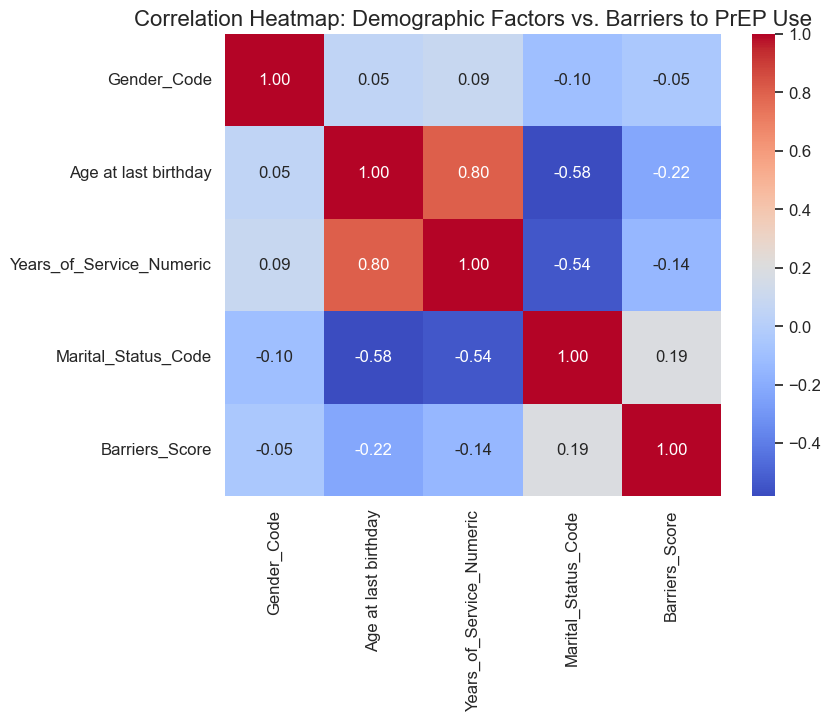

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (adjust the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Select relevant columns for the analysis
cols = ["Gender", "Age at last birthday", "Years of Military Service", "Marital Status", "Barriers_Score"]
print("Available columns:", df.columns.tolist())
df = df[cols].dropna()

# Ensure age is numeric
df["Age at last birthday"] = pd.to_numeric(df["Age at last birthday"], errors='coerce')
df = df.dropna(subset=["Age at last birthday"])

# Map "Years of Military Service" ranges to numeric midpoints
service_mapping = {
    "0 - 10 Years": 5,
    "11 - 20 Years": 15,
    "21 - 30 Years": 25,
    "31 - 40 Years": 35  # Add more mappings if applicable
}
df["Years_of_Service_Numeric"] = df["Years of Military Service"].map(service_mapping)
df = df.dropna(subset=["Years_of_Service_Numeric"])

# Convert categorical columns ("Gender" and "Marital Status") to numeric codes
df["Gender_Code"] = pd.Categorical(df["Gender"]).codes
df["Marital_Status_Code"] = pd.Categorical(df["Marital Status"]).codes

# Create a new DataFrame with numeric columns for correlation analysis
numeric_cols = ["Gender_Code", "Age at last birthday", "Years_of_Service_Numeric", "Marital_Status_Code", "Barriers_Score"]
corr_df = df[numeric_cols]

# Compute the correlation matrix
corr_matrix = corr_df.corr()

# Plot the heat map
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Demographic Factors vs. Barriers to PrEP Use")
plt.show()

## (iii) Box plots comparing attitude scores across different demographic segments

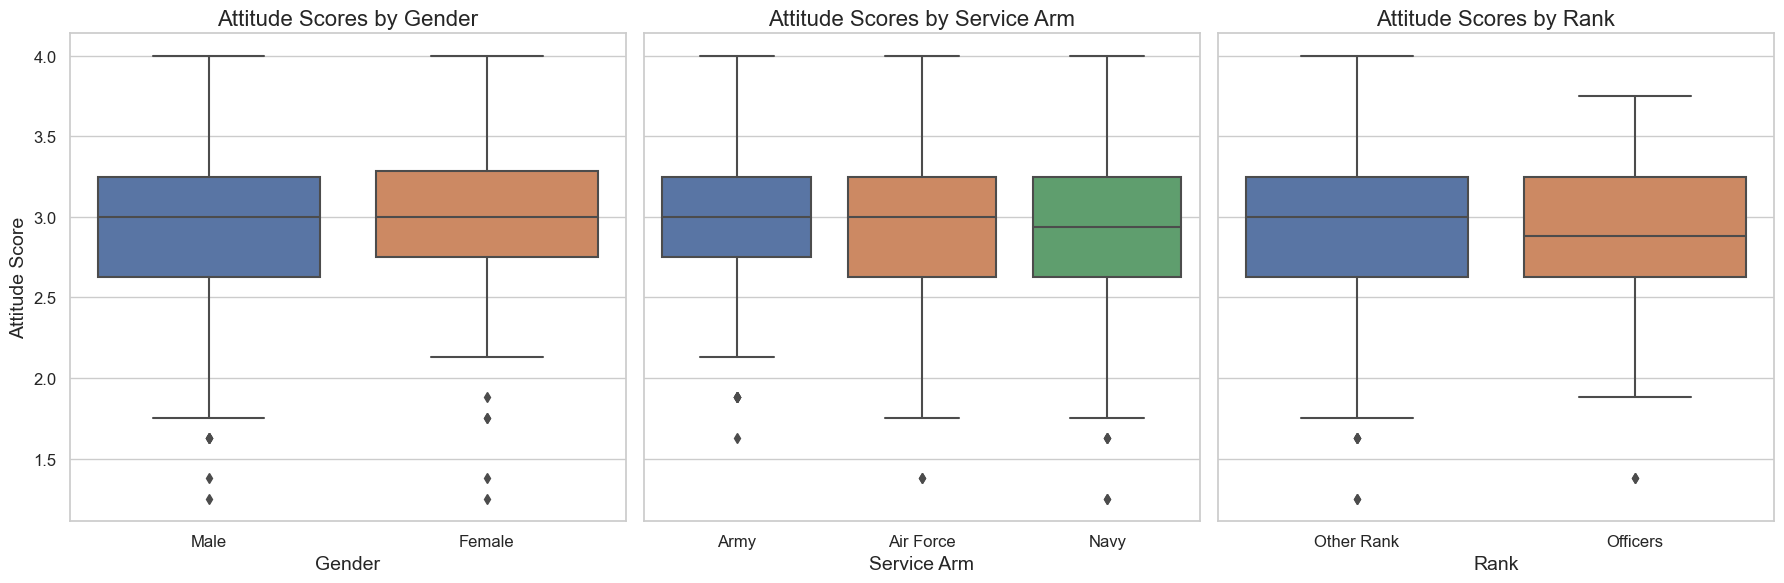

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Drop rows with missing values in the columns of interest
columns_of_interest = ["Attitude_Score", "Gender", "Service Arm", "Rank"]
df = df.dropna(subset=columns_of_interest)

# List the demographic segments to compare
demographic_columns = ["Gender", "Service Arm", "Rank"]

# Create subplots for each demographic variable
fig, axes = plt.subplots(1, len(demographic_columns), figsize=(18, 6), sharey=True)

for i, demo in enumerate(demographic_columns):
    sns.boxplot(x=demo, y="Attitude_Score", data=df, ax=axes[i])
    axes[i].set_title(f"Attitude Scores by {demo}")
    axes[i].set_xlabel(demo)
    if i == 0:
        axes[i].set_ylabel("Attitude Score")
    else:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

# Predictive Insights

## (i) 	ROC curves for classification model performance

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


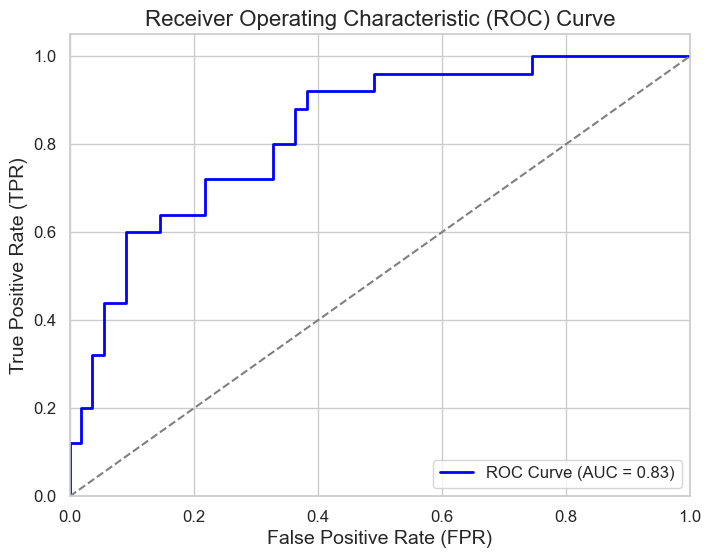


📌 AUC Score: 0.8298


In [282]:
# ✅ Ensure that X_test has the same features as X_train
X_test_fixed = X_test[X_train.columns]  # ✅ Match test columns to train

# ✅ Convert both training and test sets to NumPy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test_fixed.to_numpy()

# 📌 **Predict Probabilities for ROC Curve**
y_prob = mlp.predict_proba(X_test_np)[:, 1]  # Probabilities for class 1 (PrEP consideration)

# 📌 **Compute ROC Curve Values**
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 📊 **Plot ROC Curve**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 📌 Print AUC Score
print(f"\n📌 AUC Score: {roc_auc:.4f}")

# Relationship Analyses

## (i) Scatter plots with regression lines showing relationships between: 
    (i) Age vs. knowledge scores
    (ii) Knowledge scores vs. attitude scores


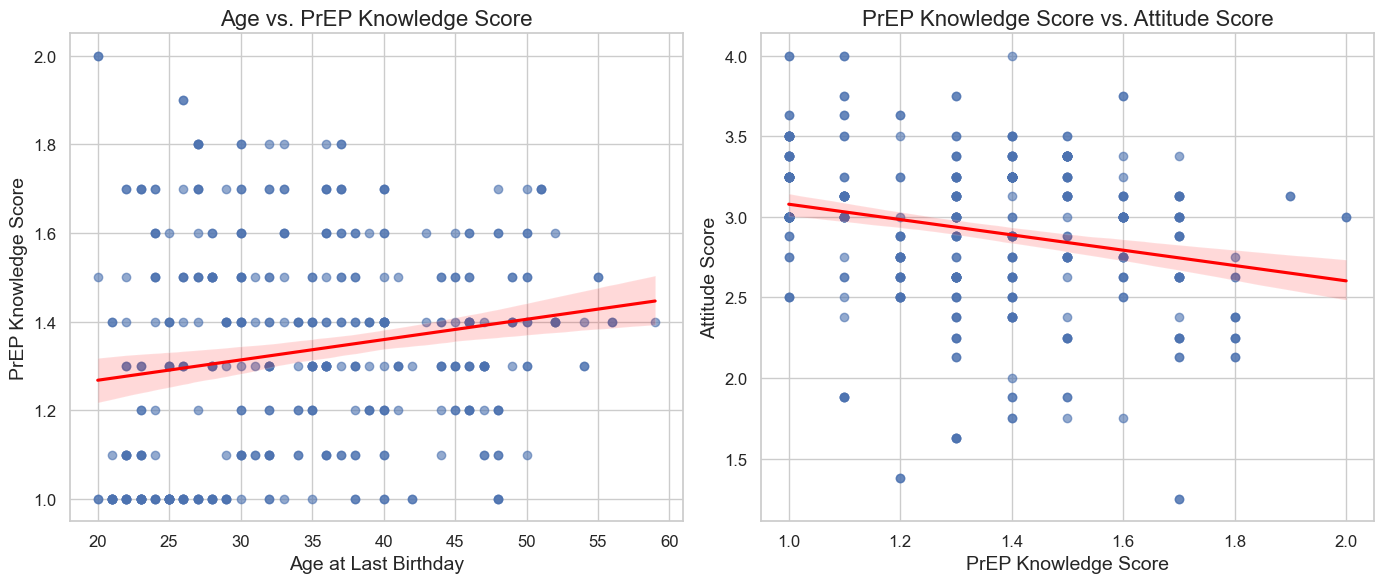

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Select relevant columns and drop rows with missing values for the analysis
cols = ["Age at last birthday", "PrEP_Knowledge_Score", "Attitude_Score"]
df = df[cols].dropna()

# Convert age and scores to numeric if they are not already
df["Age at last birthday"] = pd.to_numeric(df["Age at last birthday"], errors='coerce')
df["PrEP_Knowledge_Score"] = pd.to_numeric(df["PrEP_Knowledge_Score"], errors='coerce')
df["Attitude_Score"] = pd.to_numeric(df["Attitude_Score"], errors='coerce')

# Drop any rows with conversion errors (NaN values)
df = df.dropna()

# Set up the figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot with regression line: Age vs. Knowledge Score
sns.regplot(x="Age at last birthday", y="PrEP_Knowledge_Score", data=df, ax=axes[0],
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[0].set_title("Age vs. PrEP Knowledge Score")
axes[0].set_xlabel("Age at Last Birthday")
axes[0].set_ylabel("PrEP Knowledge Score")

# Scatter plot with regression line: Knowledge Score vs. Attitude Score
sns.regplot(x="PrEP_Knowledge_Score", y="Attitude_Score", data=df, ax=axes[1],
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[1].set_title("PrEP Knowledge Score vs. Attitude Score")
axes[1].set_xlabel("PrEP Knowledge Score")
axes[1].set_ylabel("Attitude Score")

plt.tight_layout()
plt.show()

## (ii) Correlation matrix heatmap of all numerical variables

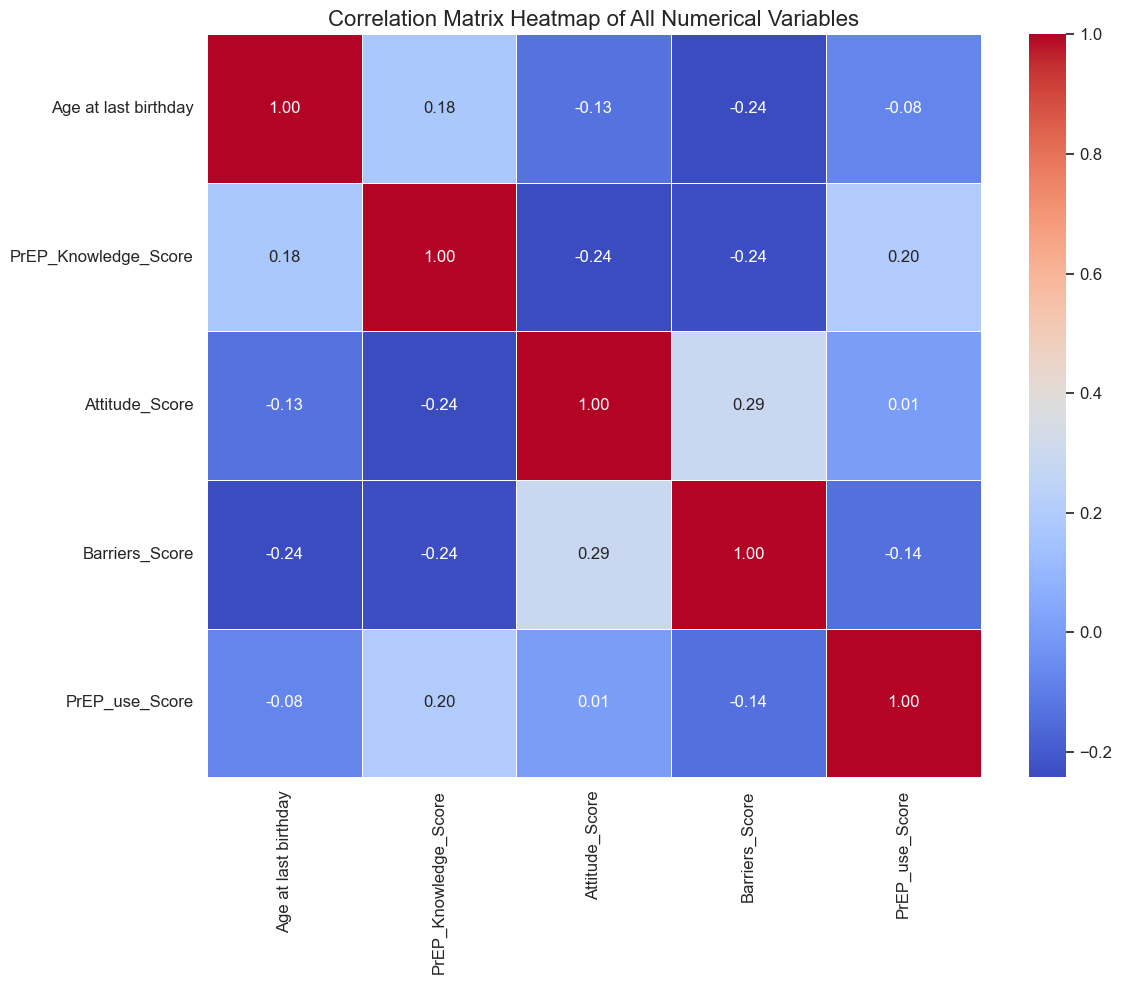

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (update the file path as needed)
df = pd.read_csv(r"C:\ArmedForces_PrEP.csv")

# Optionally convert columns to numeric (if necessary) and drop non-numeric columns
# Here we select columns with numeric dtypes only
numeric_df = df.select_dtypes(include=['number'])

# Alternatively, if you need to force conversion:
# numeric_df = df.apply(pd.to_numeric, errors='coerce')
# numeric_df = numeric_df.dropna(axis=1, how='all')  # Drop columns that couldn't be converted

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap of All Numerical Variables", fontsize=16)
plt.tight_layout()
plt.show()